In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
import os

INTERPOLATE = True

# Load the datasets first

In [ ]:
DATA_DIR = os.path.join(os.getcwd(), '../data/data.sqlite')
conn = sqlite3.connect(DATA_DIR)
df_gdp = pd.read_sql_query('SELECT * FROM gdp_data', conn)
df_live_male = pd.read_sql_query('SELECT * FROM life_expectancy_data_male', conn)
df_live_female = pd.read_sql_query('SELECT * FROM life_expectancy_data_female', conn)
df_live_total = pd.read_sql_query('SELECT * FROM life_expectancy_data_total', conn)

df_gdp.head()

,Country Name,Country Code,1960,1961,1962,1963,1964,1965,1966,1967,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Aruba,ABW,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,25813.576727,26129.839062,27458.225331,27441.529662,28440.051964,30082.127645,31096.205074,22855.932320,27200.061079,30559.533535
1,Argentina,ARG,0.000000,0.000000,1160.306598,852.972425,1176.200862,1281.833380,1275.078434,1063.932838,...,12963.675773,12233.144412,13679.626498,12699.962314,14532.500931,11752.799892,9955.974787,8535.599380,10738.017922,13935.681111
2,Antigua and Barbuda,ATG,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,15050.712277,15533.483125,16080.658050,16557.843175,16924.789449,18273.427068,18884.372968,15360.454416,17340.379069,20117.765331
3,"Bahamas, The",BHS,1459.253539,1555.046304,1651.218295,1759.236577,1883.443491,2029.523016,2239.239640,2452.747632,...,27432.953427,28705.617084,30289.402251,30266.585922,31337.183246,32124.405106,32979.540128,25155.672543,28682.327000,33044.388209
4,Belize,BLZ,307.414508,320.029477,331.704794,341.932584,356.235408,383.186435,411.933020,426.264071,...,5950.202999,6128.142885,6154.495935,6142.498732,6072.582676,6031.281396,6190.047923,5227.193638,6122.611586,7068.454783


### Interpolate the data to make it clean

The interpolation works as follows:
1. 

In [12]:
def interpolate(dataframe):
    years = dataframe.select_dtypes(include='number').columns
    data = []
    avg_growth = np.zeros(len(years))
    avg_counter = np.zeros(len(years))
    for index, row in dataframe.iterrows():
        split = []
        timeline = []
        start = False
        last_year = 0
        for i, year in enumerate(years):
            split.append(row[year])
            if last_year != 0 and row[year] != 0:
                avg_growth[i] += row[year] / last_year
                avg_counter[i] += 1
            last_year = row[year]

            if row[year] == 0 and i == 0:
                start = True
            elif row[year] != 0:
                if start and len(timeline) == 0:
                    timeline.append(np.array(split))
                    split = []
        timeline.append(np.array(split))
        data.append(timeline)
    for i in range(1, len(avg_growth)):
        avg_growth[i] /= avg_counter[i]

    new_data = []
    for timeline in data:
        if len(timeline) > 1:
            if timeline[0][0] == 0:
                if timeline[0][-1] == 0:
                    print('Invalid timeline: ' + str(timeline))
                for i in reversed(range(len(timeline[0]) - 1)):
                    if timeline[0][i] == 0:
                        timeline[0][i] = timeline[0][i + 1] / avg_growth[i + 1]
                    else:
                        print('Interpolating A')
            new_data.append(np.concatenate([timeline[0], timeline[1]]))
        else:
            new_data.append(timeline[0])

    index = 0
    for timeline in new_data:
        for i in range(1, len(timeline)):
            if timeline[i] == 0:
                timeline[i] = timeline[i - 1] * avg_growth[i]

        # Write the updated timeline back to df_gdp
        for j, year in enumerate(years):
            if dataframe.at[index, year] == 0:
                dataframe.at[index, year] = timeline[j]
        index += 1
    return dataframe

if INTERPOLATE:
    df_gdp = interpolate(df_gdp)
    df_live_male = interpolate(df_live_male)
    df_live_female = interpolate(df_live_female)
    df_live_total = interpolate(df_live_total)

# Sort the data after best Value in the last comlumn
df_gdp = df_gdp.sort_values(by=df_gdp.columns[-1], ascending=False)
df_live_male = df_live_male.sort_values(by=df_live_male.columns[-1], ascending=False)
df_live_female = df_live_female.sort_values(by=df_live_female.columns[-1], ascending=False)
df_live_total = df_live_total.sort_values(by=df_live_total.columns[-1], ascending=False)
df_gdp.head()

,Country Name,Country Code,1960,1961,1962,1963,1964,1965,1966,1967,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
5,Bermuda,BMU,1715.314632,1773.995316,1824.182283,1821.790913,1986.640810,2064.853248,2369.472947,2722.462334,...,101704.407462,100961.576603,104855.366822,108747.356144,112339.425587,113204.822108,115798.040776,106973.175732,112712.025121,120897.311155
15,Cayman Islands,CYM,3609.320717,3754.260424,3938.320985,4064.306771,4380.621236,4648.198559,4946.163131,5146.529731,...,75113.733240,75845.306041,76379.209511,77802.254157,80053.944451,83865.553157,88254.290368,82338.798285,86438.445257,92202.147803
41,United States,USA,2999.864872,3059.160821,3236.013112,3366.369790,3565.314430,3818.288251,4136.308296,4325.959351,...,53409.750777,55304.315532,57040.208214,58206.614193,60322.261424,63201.045848,65604.681520,64411.373178,71318.307359,78035.175360
20,Greenland,GRL,897.326324,933.360310,979.120274,1010.442058,1089.082145,1155.605514,1229.683568,1279.497436,...,47535.488379,50485.224414,44536.354971,48181.745354,50765.749467,54545.135858,53309.203591,54693.076680,57116.295771,64721.294957
9,Canada,CAN,2264.948497,2246.083566,2274.428471,2380.317329,2561.638491,2777.183173,3055.288079,3226.382737,...,52638.118724,50960.843117,43594.194105,42314.061582,45129.628117,46539.176157,46352.869345,43537.839299,52496.844169,55509.393176


### Plot the GDP Data and Live Expecity

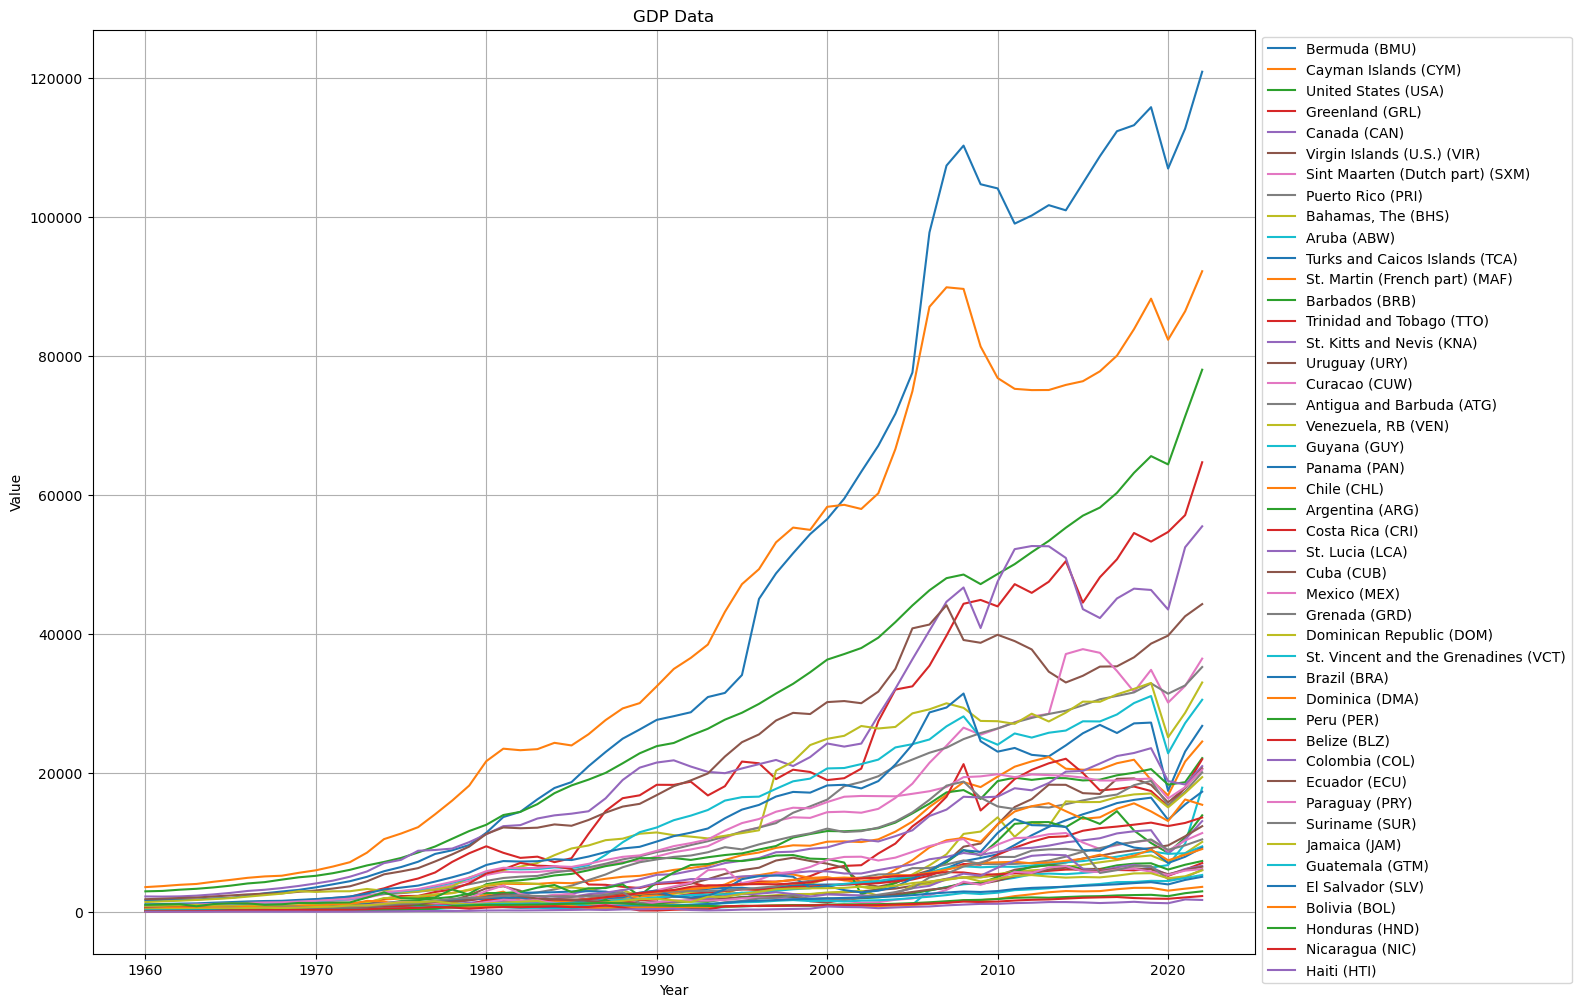

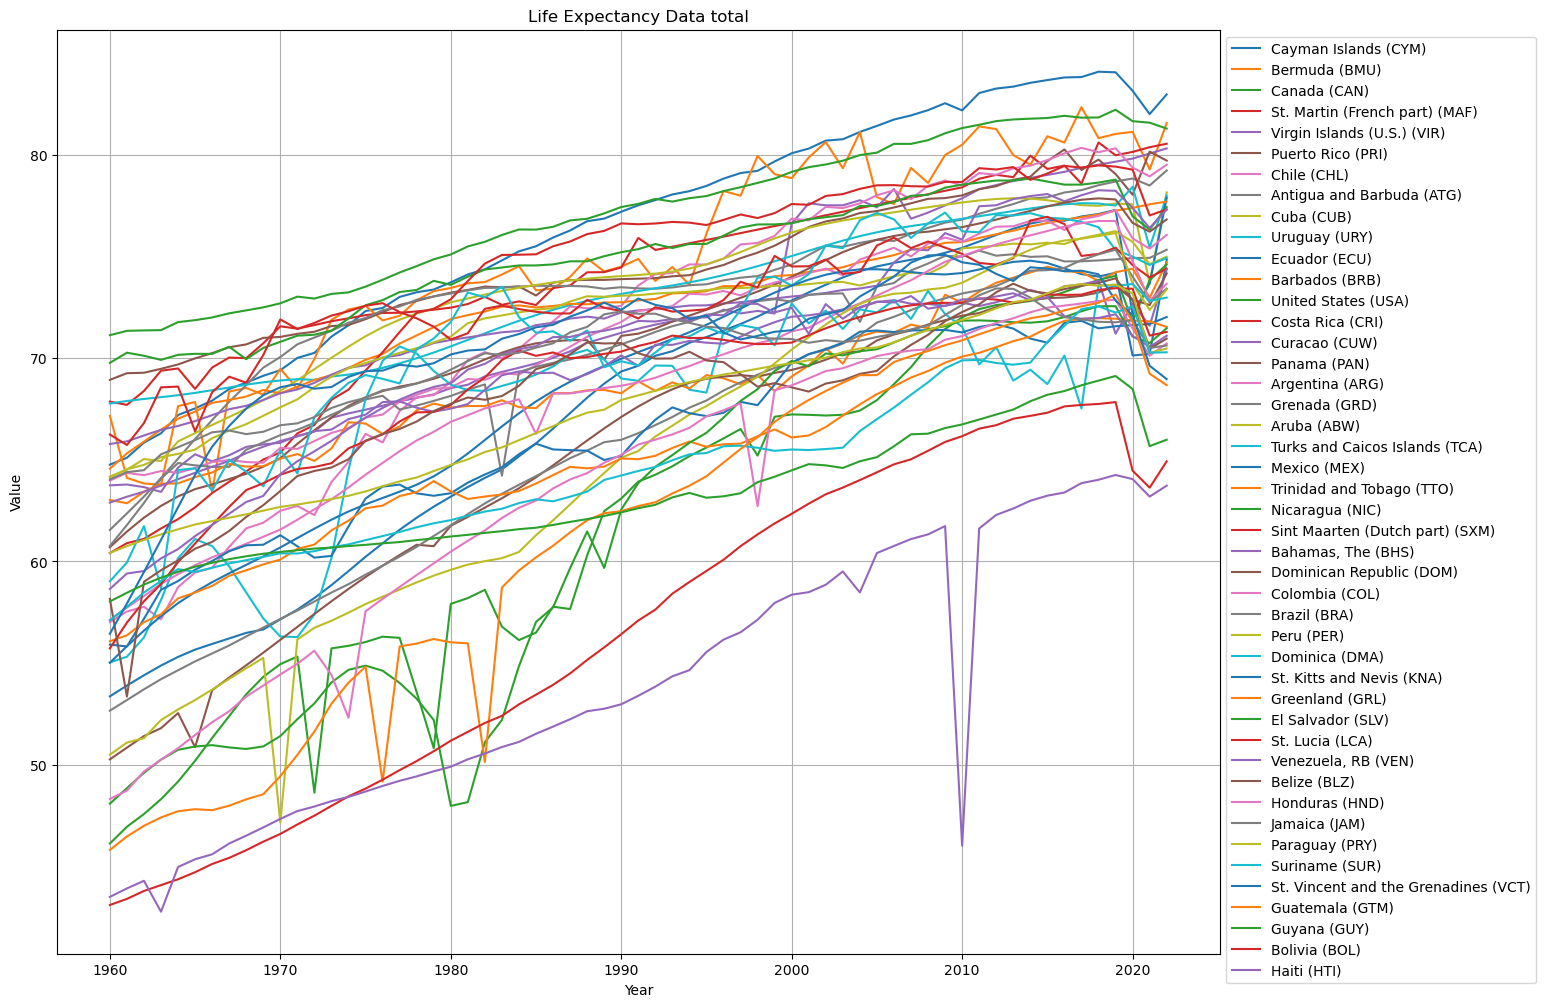

In [9]:
def plot_data_raw(dataframe, title):
    years = dataframe.select_dtypes(include='number').columns.astype(int).to_numpy()

    plt.figure(figsize=(15, 12))

    for _, row in dataframe.iterrows():
        plt.plot(years, row[2:].values, label=row['Country Name'] + ' (' + row['Country Code'] + ')')

    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel('Value')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)
    plt.grid(True)
    plt.show()

plot_data_raw(df_gdp, 'GDP Data')
# plot_data_raw(df_live_male, 'Life Expectancy Data for males')
# plot_data_raw(df_live_female, 'Life Expectancy Data for females')
plot_data_raw(df_live_total, 'Life Expectancy Data total')

In the next step we look into the derivate change of the data.

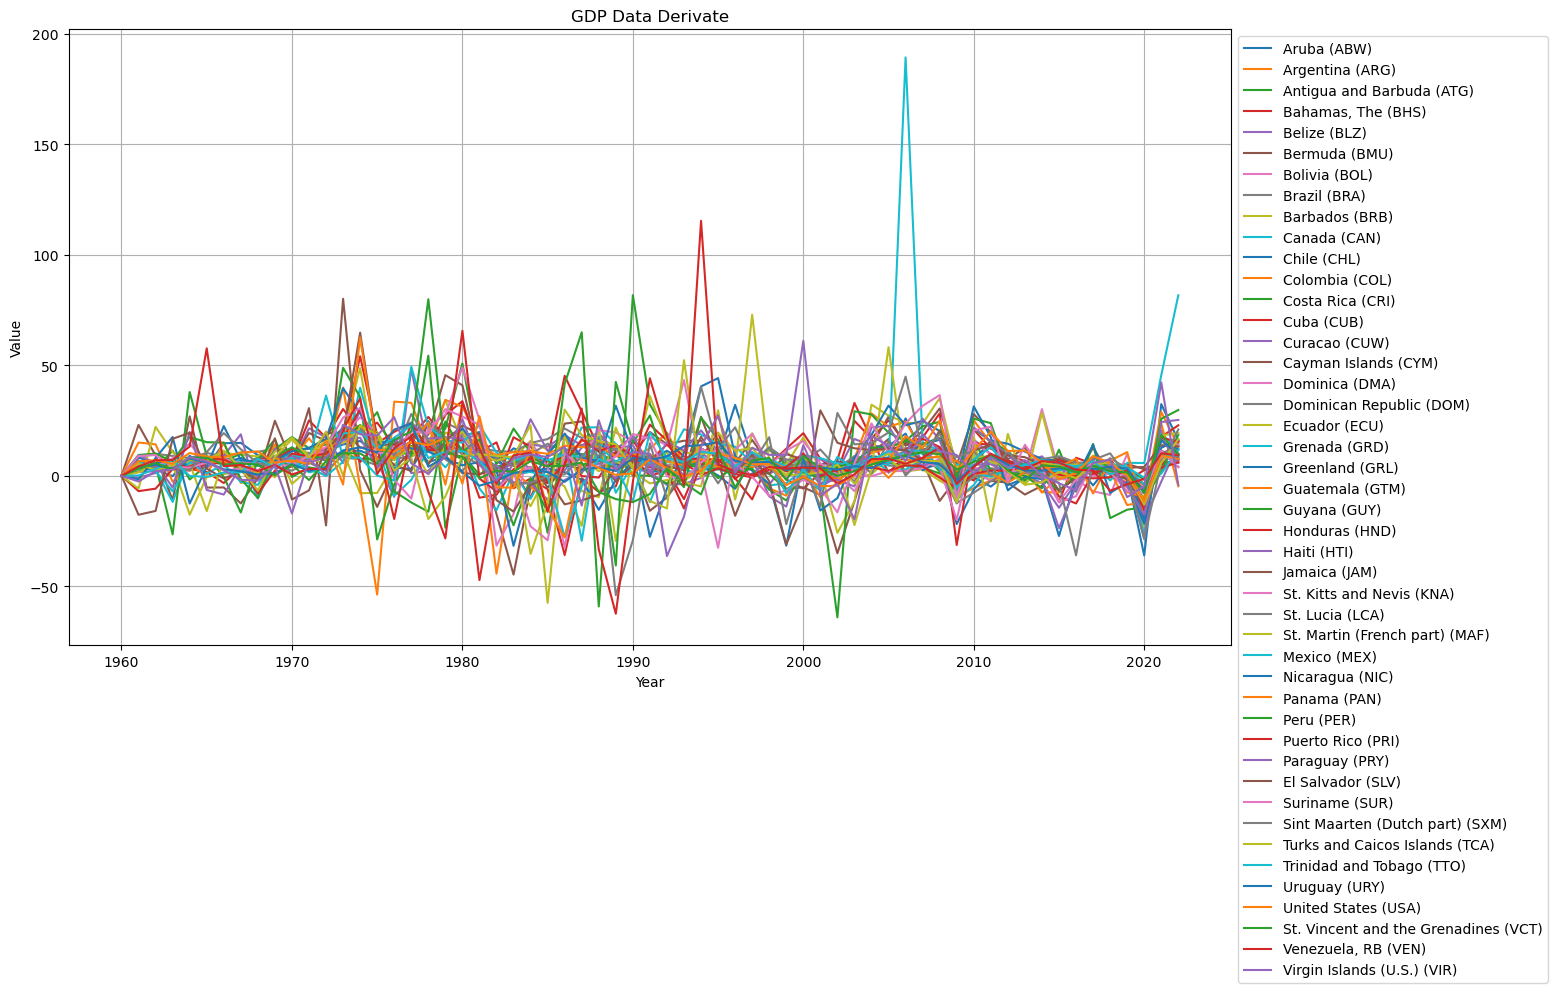

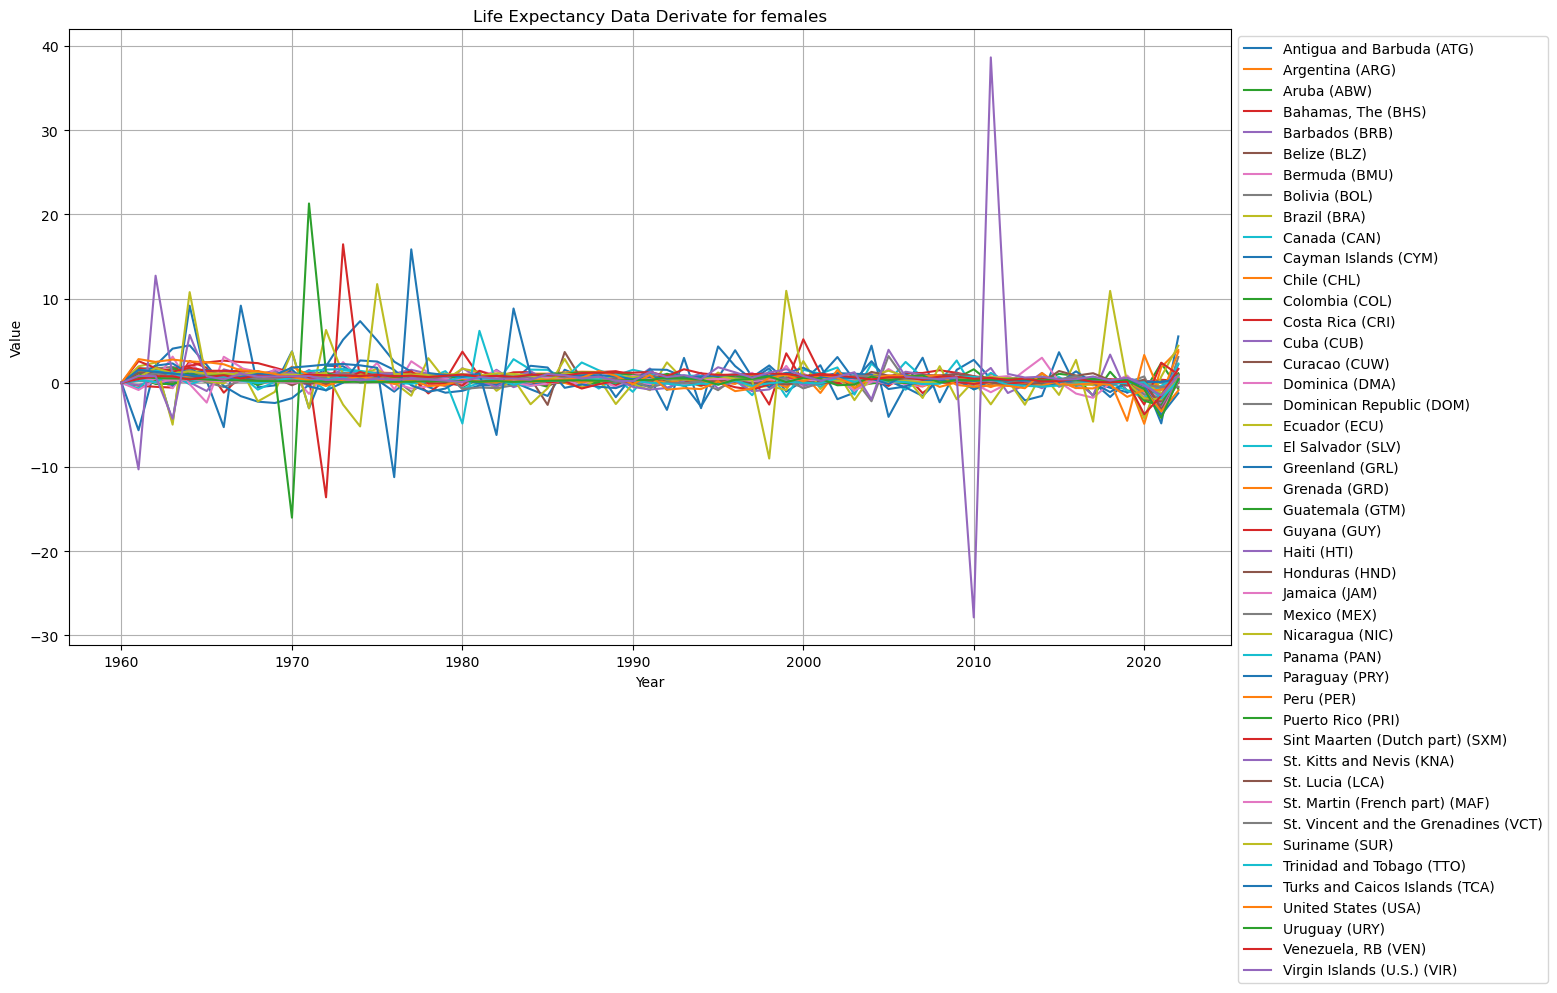

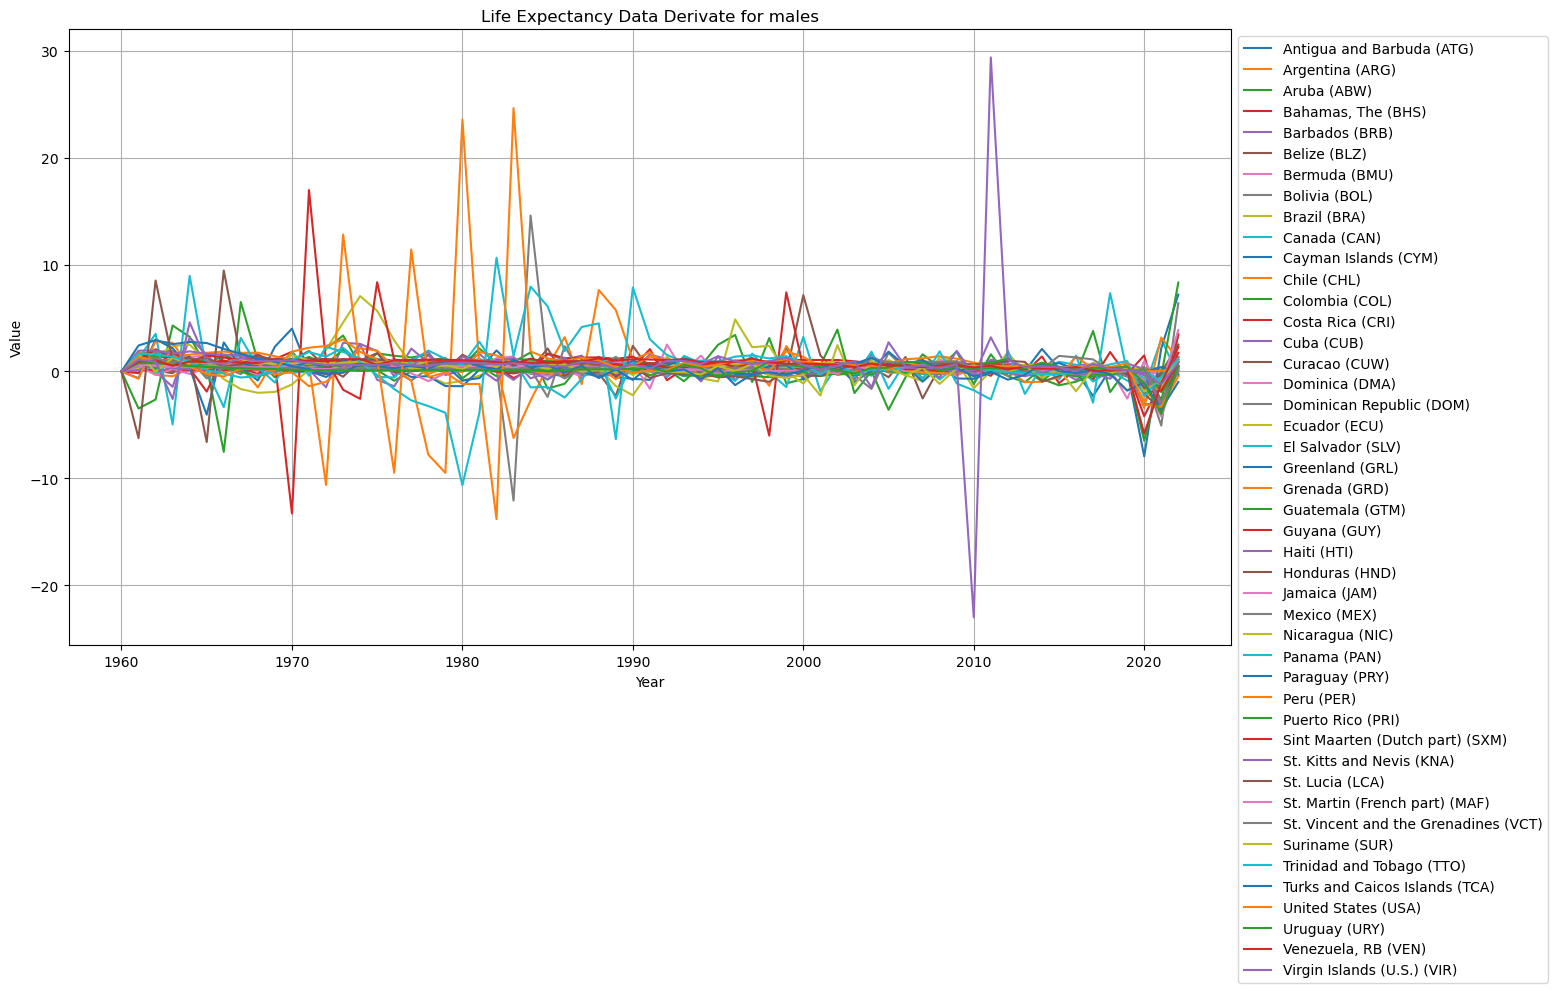

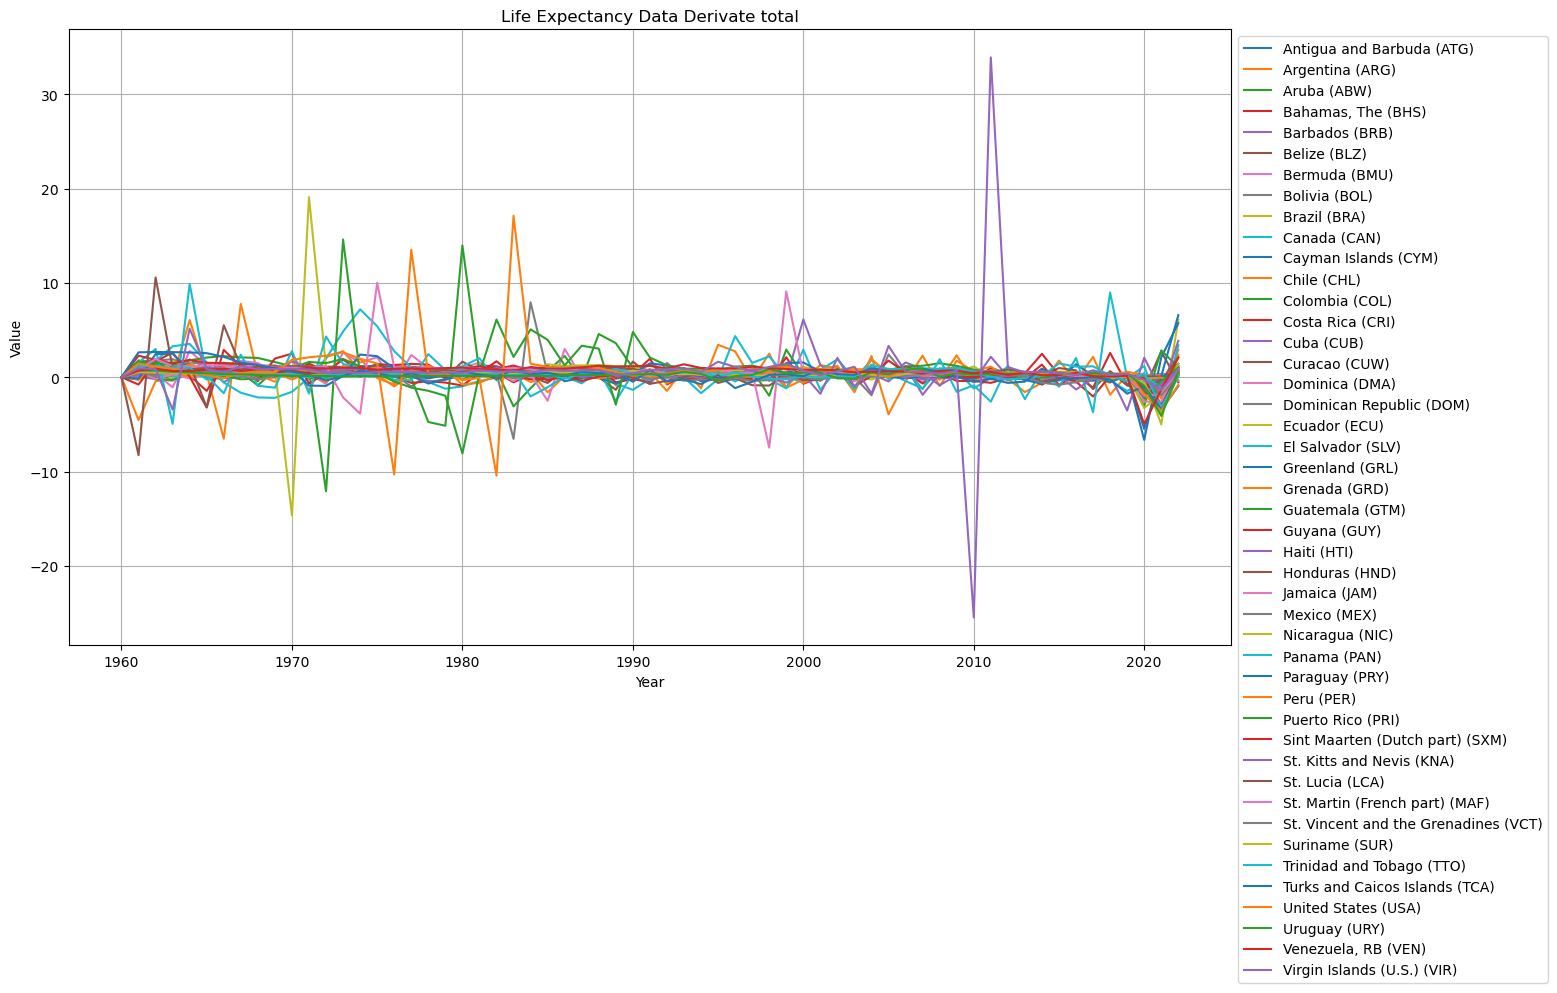

In [5]:
def caluculate_derivate(dataframe):
    years = dataframe.select_dtypes(include='number').columns
    data = []
    for _, row in dataframe.iterrows():
        split = []
        for i, year in enumerate(years):
            if i == 0:
                split.append(0)
            else:
                split.append((row[year] / row[years[i - 1]] -1) * 100)
        data.append(split)
    
    derivate_df = pd.DataFrame(data, columns=years)
    derivate_df.insert(0, 'Country Name', dataframe['Country Name'])
    derivate_df.insert(1, 'Country Code', dataframe['Country Code'])
    return derivate_df

df_gdp_derivate = caluculate_derivate(df_gdp)
df_live_male_derivate = caluculate_derivate(df_live_male)
df_live_female_derivate = caluculate_derivate(df_live_female)
df_live_total_derivate = caluculate_derivate(df_live_total)

plot_data_raw(df_gdp_derivate, 'GDP Data Derivate')
plot_data_raw(df_live_female_derivate, 'Life Expectancy Data Derivate for females')
plot_data_raw(df_live_male_derivate, 'Life Expectancy Data Derivate for males')
plot_data_raw(df_live_total_derivate, 'Life Expectancy Data Derivate total')

Plot the relationship between gdp and live 

Korrelation zwischen GDP und Lebenserwartung:


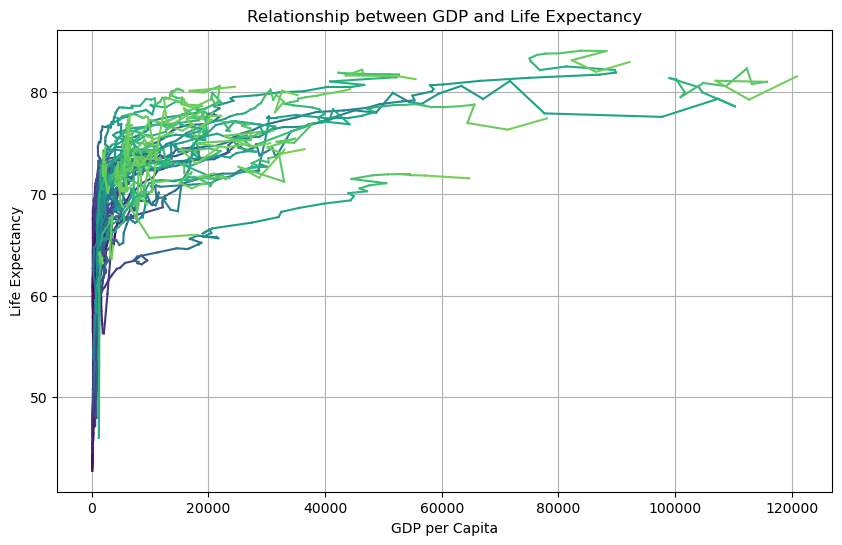

Korrelation zwischen GDP und Lebenserwartung:


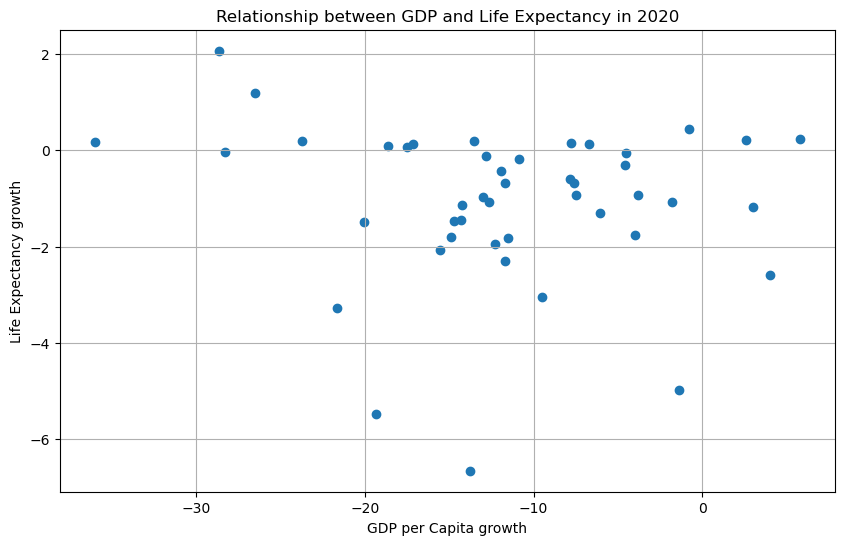

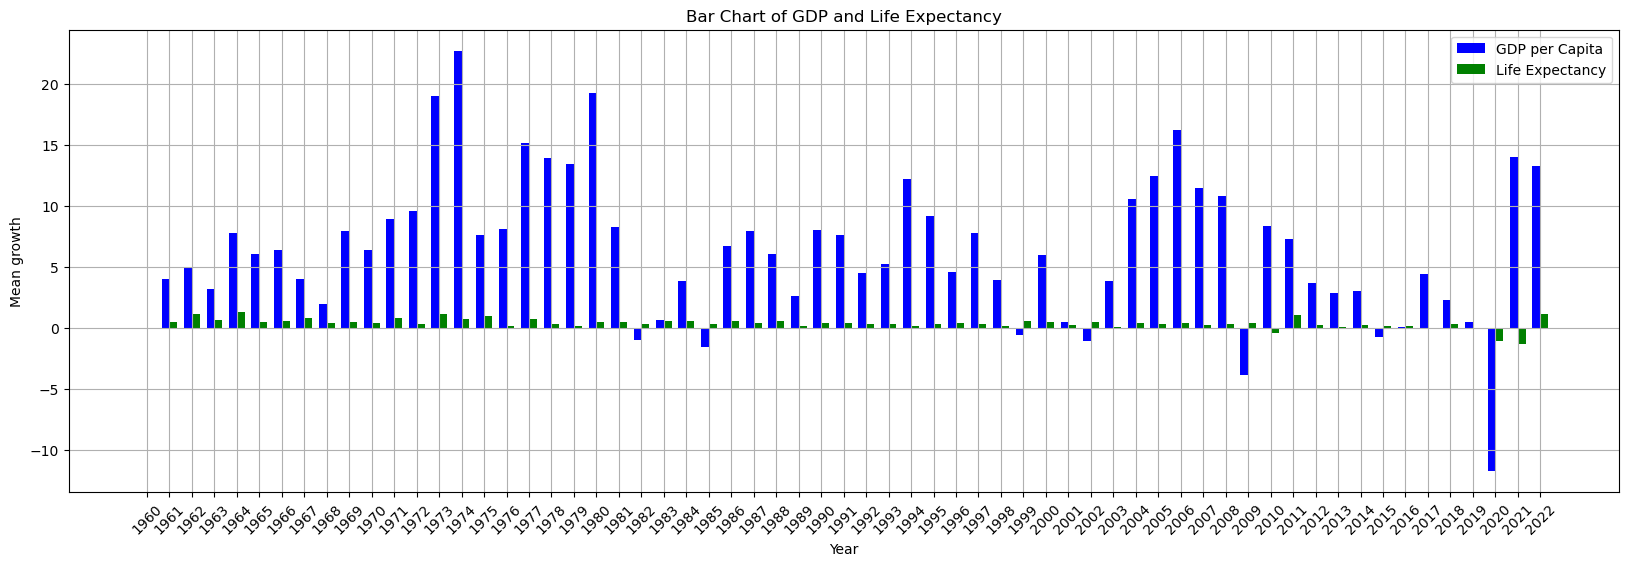

/tmp/ipykernel_2752/3288660883.py:57: RuntimeWarning: invalid value encountered in true_divide
  positive_factors = np.where(gdp_means / life_expectancy_means > 0, gdp_means / life_expectancy_means, 0)
/tmp/ipykernel_2752/3288660883.py:58: RuntimeWarning: invalid value encountered in true_divide
  negative_factors = np.where(gdp_means / life_expectancy_means < 0, gdp_means / life_expectancy_means, 0)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


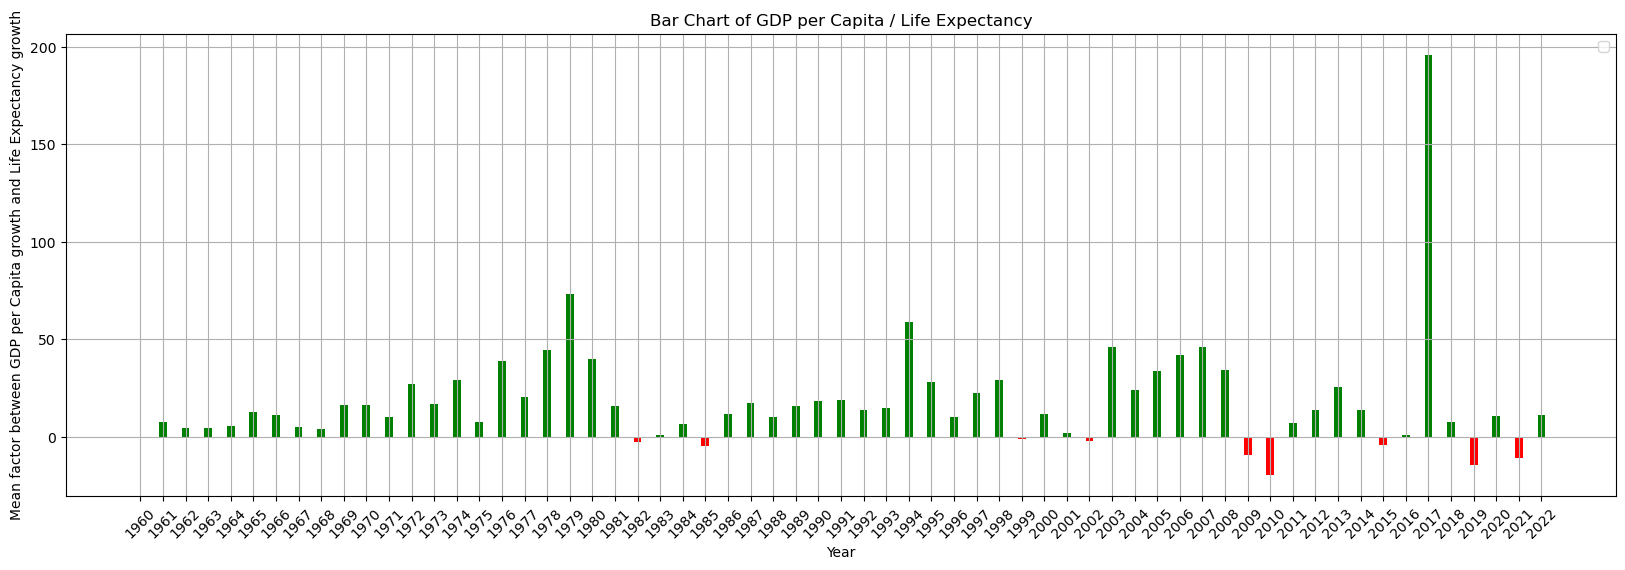

In [6]:
def plot_correlation_line(df_gdp, df_live):
    df_merged = pd.merge(df_gdp, df_live, on=['Country Name', 'Country Code'], suffixes=('_GDP', '_Life_Expectancy'))
    print("Korrelation zwischen GDP und Lebenserwartung:")
    years = df_gdp.select_dtypes(include='number').columns
    plt.figure(figsize=(10, 6))
    colors = plt.cm.viridis(np.linspace(0, 0.8, len(years)))
    for index, row in df_merged.iterrows():
        gdp_values = row.filter(like='_GDP').to_numpy().astype(float)
        life_expectancy_values = row.filter(like='_Life_Expectancy').to_numpy().astype(float)
        for i in range(len(years) - 1):
            plt.plot(gdp_values[i:i+2], life_expectancy_values[i:i+2], color=colors[i])

    plt.title('Relationship between GDP and Life Expectancy')
    plt.xlabel('GDP per Capita')
    plt.ylabel('Life Expectancy')
    plt.grid(True)
    plt.show()

def plot_correlation_dot(df_gdp, df_live):
    df_merged = pd.merge(df_gdp, df_live, on=['Country Name', 'Country Code'], suffixes=('_GDP', '_Life_Expectancy'))
    print("Korrelation zwischen GDP und Lebenserwartung:")
    years = df_gdp.select_dtypes(include='number').columns
    summary_data = []
    for year in years:
        if year == '2020':
            plt.figure(figsize=(10, 6))
            plt.scatter(df_merged[f'{year}_GDP'], df_merged[f'{year}_Life_Expectancy'])
            plt.title(f'Relationship between GDP and Life Expectancy in {year}')
            plt.xlabel('GDP per Capita growth')
            plt.ylabel('Life Expectancy growth')
            plt.grid(True)
            plt.show()
        
        summary_data.append((int(year), df_merged[f'{year}_GDP'].mean(), df_merged[f'{year}_Life_Expectancy'].mean()))
    
    summary_data = np.array(summary_data)
    years = summary_data[:, 0]
    gdp_means = summary_data[:, 1]
    life_expectancy_means = summary_data[:, 2]

    bar_width = 0.35  # Width of the bars
    index = np.arange(len(years))  # The x locations for the groups

    plt.figure(figsize=(20, 6))
    plt.bar(index, gdp_means, bar_width, label='GDP per Capita', color='blue')
    plt.bar(index + bar_width, life_expectancy_means, bar_width, label='Life Expectancy', color='green')

    plt.xlabel('Year')
    plt.ylabel('Mean growth')
    plt.title('Bar Chart of GDP and Life Expectancy')
    plt.xticks(index + bar_width / 2, years.astype(int), rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(20, 6))
    positive_factors = np.where(gdp_means / life_expectancy_means > 0, gdp_means / life_expectancy_means, 0)
    negative_factors = np.where(gdp_means / life_expectancy_means < 0, gdp_means / life_expectancy_means, 0)
    plt.bar(index, positive_factors, bar_width, color='green')
    plt.bar(index, negative_factors, bar_width, color='red')
    plt.ylabel('Mean factor between GDP per Capita growth and Life Expectancy growth')
    plt.xlabel('Year')
    plt.title('Bar Chart of GDP per Capita / Life Expectancy')
    plt.xticks(index, years.astype(int), rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()


plot_correlation_line(df_gdp, df_live_total)
plot_correlation_dot(df_gdp_derivate, df_live_total_derivate)